# Plot figure 2

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


## Data preparation

### Definitions

In [2]:
# dictionary definitions

data_dic = {0: "blds_continent_data_18-23_ai.json",
            1: "blds_africa_states_18-23_ai.json",
            2: "blds_northamerica_states_18-23_ai.json",
            3: "blds_europe_states_18-23_ai.json",
            4: "blds_asia_states_18-23_ai.json",}
geojson_folder_dic = {0: "geojson-continent-states",
                      1: "geojson-africa-states",
                      2: "geojson-northamerica-states",
                      3: "geojson-europe-states",
                      4: "geojson-asia-states",}

In [3]:
# user input definition

while True:
    try:
        user_d_spec = int(input("Which data do you want to plot?\
                            Enter 0 for stats by continents (2018–2023),\
                            1 for stats by Africa states (2018–2023),\
                            2 for stats by North-Central America states (2018–2023),\
                            3 for stats by Europe states (2018–2023),\
                            4 for stats by Asia states (2018–2023):"
                                ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_d_spec not in range(len(data_dic)):
        print("Please enter 0, 1, 2, 3 or 4.")
        continue
    break


In [4]:
# function definitions

def data_spec(data_dic):
    
    with open(f"downloaded-data\\{data_dic[user_d_spec]}", "r") as f:
        data = json.load(f)
    return data


def get_geojson_names(home_dir, geojson_folder_dic):
    geojson_dir = os.path.join(home_dir, geojson_folder_dic[user_d_spec], "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [5]:
os.chdir('..')

data = data_spec(data_dic)

home_dir = os.getcwd()


### Edit the obtained data into desired shape to create a DataFrame

In [6]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [7]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [8]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [9]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic)


['0_Africa.geojson', '1_Asia.geojson', '2_Australia.geojson', '3_North America.geojson', '4_Oceania.geojson', '5_South America.geojson', '6_Antarctica.geojson', '7_Europe.geojson']


In [10]:
geojson_names_2 = geojson_names

id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1]
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [11]:
# merge df with region names based on ids
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
df.head()

,feature,source,timestamp,value,year,id,name
0,0,remainder,2018-01-01T00:00:00Z,29449360.0,2018,0,Africa
1,0,remainder,2019-01-01T00:00:00Z,44240256.0,2019,0,Africa
2,0,remainder,2020-01-01T00:00:00Z,54298403.0,2020,0,Africa
3,0,remainder,2021-01-01T00:00:00Z,67423672.0,2021,0,Africa
4,0,remainder,2022-01-01T00:00:00Z,80187816.0,2022,0,Africa


### Filtering the data

In [12]:
# get the number of AI Microsoft (source=microsoft/BuildingFootprints) / manually mapped (remainder) buildings for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped


In [13]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"num_of_blds", "value_y":"total_blds"})
merged_data["percentage"] = (merged_data["num_of_blds"] / merged_data["total_blds"]) * 100
# merged_data.head(10)


In [14]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source                               year
remainder                            2018    100.0
                                     2019    100.0
                                     2020    100.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
source=microsoft/BuildingFootprints  2018      0.0
                                     2019      0.0
                                     2020    100.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
Name: percentage, dtype: float64

In [15]:
# create the dataframe by the source
df_rem = merged_data.loc[(df["source"] == "remainder"),:] # remainder = manually mapped buildings
df_ai = merged_data.loc[(df["source"] == "source=microsoft/BuildingFootprints") , :] # buiildings used from Microsoft AI
# df_ai.head()


In [16]:
# exclude states which give zero in total
df_rem = df_rem.groupby("name").filter(
    lambda x: x["num_of_blds"].sum() != 0)
df_ai = df_ai.groupby("name").filter(
    lambda x: x["num_of_blds"].sum() != 0)


In [17]:
# verify the sum
# df_rem.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [18]:
# verify the sum
# df_ai.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [19]:
# how the DataFrame looks like – manually mapped buildings
df_rem.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
0,0,remainder,2018-01-01T00:00:00Z,29449360.0,2018,0,Africa,258151878.0,11.407765
1,0,remainder,2019-01-01T00:00:00Z,44240256.0,2019,0,Africa,320167900.0,13.817830
2,0,remainder,2020-01-01T00:00:00Z,54298403.0,2020,0,Africa,364680591.0,14.889304
3,0,remainder,2021-01-01T00:00:00Z,67423672.0,2021,0,Africa,418092103.0,16.126512
4,0,remainder,2022-01-01T00:00:00Z,80187816.0,2022,0,Africa,472865820.0,16.957837


In [20]:
# how the DataFrames look like – AI Microsoft buildings
df_ai.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
6,0,source=microsoft/BuildingFootprints,2018-01-01T00:00:00Z,0.0,2018,0,Africa,0.0,NaN
7,0,source=microsoft/BuildingFootprints,2019-01-01T00:00:00Z,0.0,2019,0,Africa,0.0,NaN
8,0,source=microsoft/BuildingFootprints,2020-01-01T00:00:00Z,0.0,2020,0,Africa,13935.0,0.000000
9,0,source=microsoft/BuildingFootprints,2021-01-01T00:00:00Z,219212.0,2021,0,Africa,2530556.0,8.662602
10,0,source=microsoft/BuildingFootprints,2022-01-01T00:00:00Z,269849.0,2022,0,Africa,5859157.0,4.605594


## Plots

### Manually mapped buildings

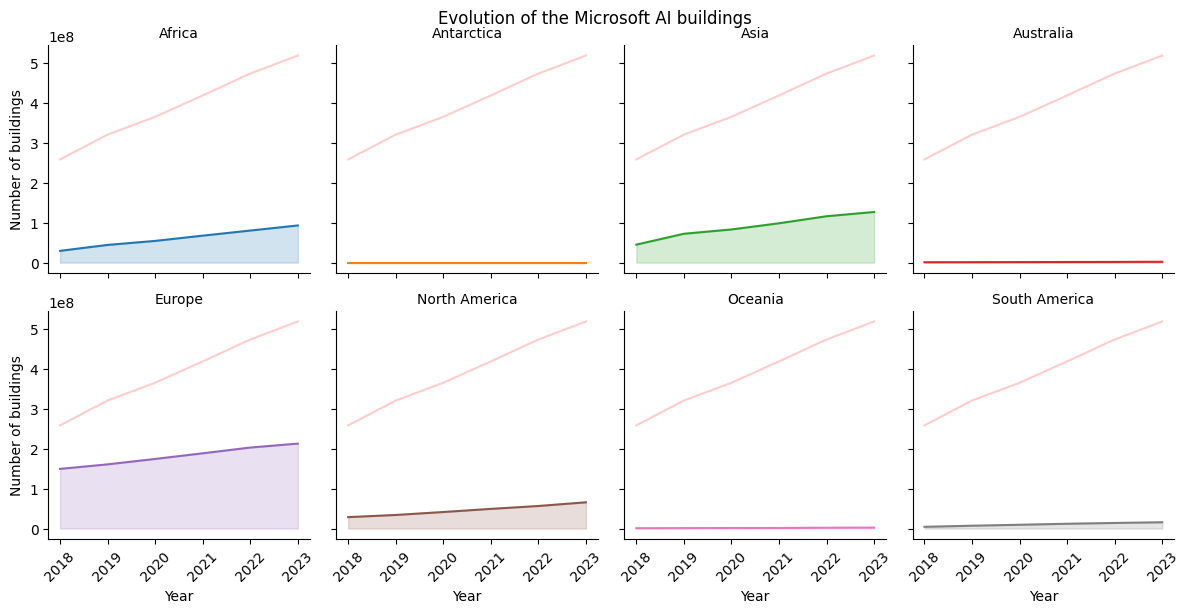

In [21]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# # add the line over the area with the plot function
# g = g.map(plt.plot, 'year', 'total_blds')

# # fill the area with fill_between
# g = g.map(plt.fill_between, 'year', 'total_blds',
#           alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# show the graph
plt.show()


### AI Microsoft buildings

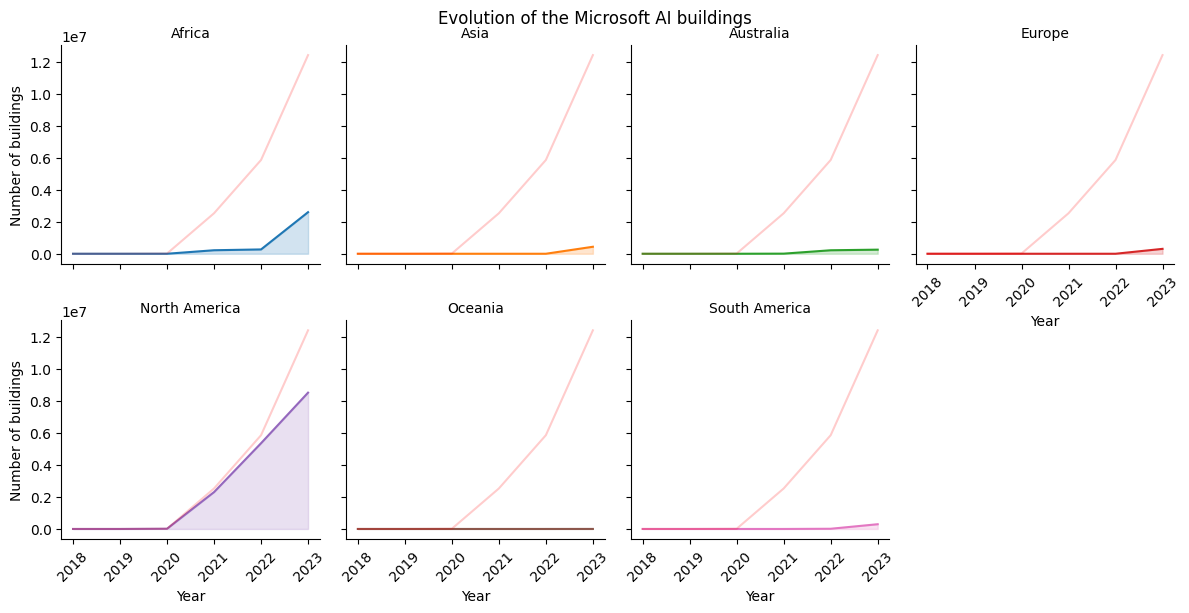

In [22]:
# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# Calculate and add total values to each subplot

# for ax in g.axes.flat:
#     # Calculate total values for each day and sex
#     totals = df_ai.groupby(['year'])[['num_of_blds']].sum()
#     # Get the day and sex for the current subplot
#     day, sex = ax.get_title().split(' = ')
#     # Add the total values to the current subplot
#     ax.text(0.05, 0.95, f"Total: ${totals.loc[day, sex]['total_bill']:.2f}, Tip: ${totals.loc[day, sex]['tip']:.2f}",
#             transform=ax.transAxes, fontsize=10, verticalalignment='top')



# show the graph
plt.show()


### AI Microsoft and Manually mapped buildings together

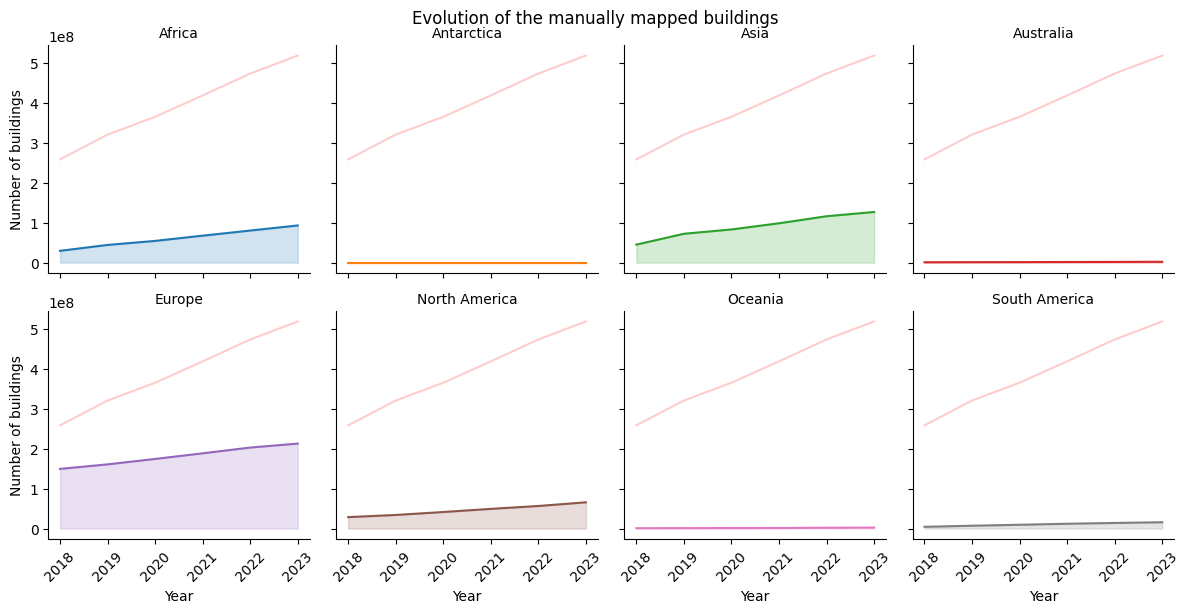

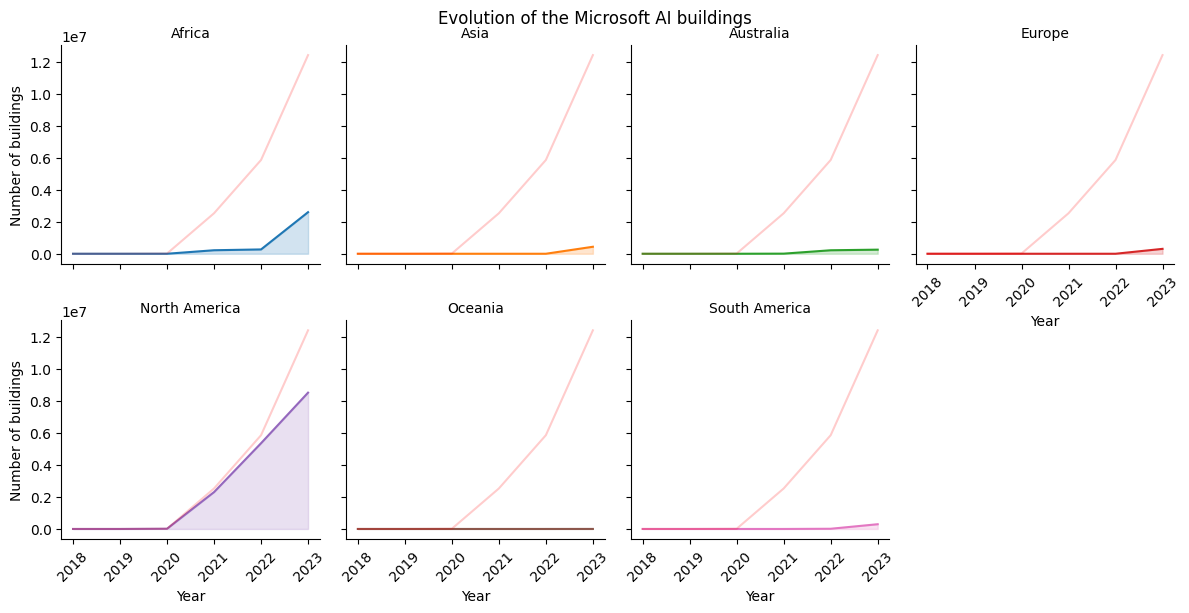

In [23]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)#.set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# g.set(ylim=(0, 100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")
    # ax.set_ylim(100)

# Show the graph
plt.show()


# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'num_of_blds')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'num_of_blds',
          alpha=0.2)  # .set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_blds', color='red', alpha=0.2)

# g.set(ylim=(0,100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI buildings')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of buildings")

# show the graph
plt.show()
